# Detect 20 different European languages

* Dataset: [http://www.statmt.org/europarl/](http://www.statmt.org/europarl/)

In [68]:
import pandas as pd
import os

## Language mapping

要把各個語言和縮寫做個 map 關聯起來

In [69]:
# map languages
lang_codes = {
    'German': 'de',
    'Danish': 'da',
    'Slovenian': 'sl',
    'Greek': 'el',
    'Spanish': 'es',
    'Finnish': 'fi',
    'French': 'fr',
    'Italian': 'it',
    'Dutch': 'nl',
    'Portuguese': 'pt',
    'Swedish': 'sv',
    'Bulgarian': 'bg',
    'Czech': 'cs',
    'Estonian': 'et',
    'Hungarian': 'hu',
    'Lithunian': 'lt',
    'Latvian': 'lv',
    'Polish': 'pl',
    'Romanian': 'ro',
    'Slovak': 'sk'
}

## Load data

In [70]:
data_dir = 'data/'

# key: sentences
# value: language
target_dict = {}

* 從每個語言裡選出 50000 個句子，每個句子至少要包含 30 個字元
  * 選擇第 10,000 ~ 第 60,000 句
* Select 5000 sentences from each language that are at least 30 characters

In [71]:
for root, dirs, files in os.walk(data_dir):
#     print(root, dirs, files)
    for file in files:
        if file == '.DS_Store':
            continue
        filename = os.path.join(root, file)
#         print(os.path.join(root, file))
        lang = filename[5:7]
#         print(lang)

        # Get the full name of language
        name = None
        for key, value in lang_codes.items():
            if value == lang:
                name = key
#         print(name)

        if filename[-2:] == lang:
            with open(filename, 'r', encoding='utf-8') as fin:
                for i, line in enumerate(fin):
                    if 10000 <= i <= 60000:
                        if len(line) > 30:
                            target_dict[line] = name

In [72]:
print(len(target_dict))

954246


In [73]:
text = list(target_dict.keys())
language = list(target_dict.values())

print(len(text))
print(len(language))

954246
954246


## DataFrame

Convert into Pandas DataFrame

In [74]:
df = pd.DataFrame()
df['text'] = text
df['language'] = language
df.head()

,text,language
0,"Norime klasinių veiksmų, kurie padėtų mūsų pil...",Lithunian
1,"Žinoma, nenorime įvesti JAV sąlygų.\n",Lithunian
2,Kalbame apie mūsų piliečių galimybes naudotis ...,Lithunian
3,"Manau, kad labai gaila, kad jūsų grupvis dar t...",Lithunian
4,"Tikrai turėtumėte pagalvoti, ko iš tikrųjų nor...",Lithunian


## Data Preprocessing

* 用 regular expension 把 puctuation 移除
* shuffle


In [75]:
import re

df['cleaned'] = df['text'].apply(lambda x: ' '.join([i for i in re.sub('[<(!?).,*>]', ' ', x).split()]))

# Shuffle
df = df.sample(frac=1).reset_index(drop=True)

df.head()

,text,language,cleaned
0,"Prav tako je pomembno, da direktiva zajema pon...",Slovenian,Prav tako je pomembno da direktiva zajema pona...
1,Geneven yleissopimuksiin on kirjattu valtioide...,Finnish,Geneven yleissopimuksiin on kirjattu valtioide...
2,När det gäller det ekonomiska och finansiella ...,Swedish,När det gäller det ekonomiska och finansiella ...
3,"Arvoisa puhemies, komissio ansaitsee, kuten mu...",Finnish,Arvoisa puhemies komissio ansaitsee kuten muis...
4,Proto je ještě důležitější dobré sladění a koo...,Czech,Proto je ještě důležitější dobré sladění a koo...


* mapping languages to integer

In [76]:
df.language.unique()

array(['Slovenian', 'Finnish', 'Swedish', 'Czech', 'Greek', 'Lithunian',
       'Latvian', 'Hungarian', 'Bulgarian', 'Spanish', 'Polish',
       'Portuguese', 'French', 'Danish', 'Dutch', 'Slovak', 'Estonian',
       'Italian', 'German', 'Romanian'], dtype=object)

In [77]:
label_encoding = {
    'Slovenian': 1,
    'Danish': 2,
    'Slovak': 3,
    'Greek': 4,
    'German': 5,
    'Spanish': 6,
    'Finnish': 7,
    'French': 8,
    'Italian': 9,
    'Dutch': 10,
    'Portuguese': 11,
    'Swedish': 12,
    'Bulgarian': 13,
    'Czech': 14,
    'Estonian': 15,
    'Hungarian': 16,
    'Lithunian': 17,
    'Latvian': 18,
    'Polish': 19,
    'Romanian': 20
}

df['code'] = df['language'].map(label_encoding)
print(df.isnull().any())

text        False
language    False
cleaned     False
code        False
dtype: bool


In [78]:
df.head()

,text,language,cleaned,code
0,"Prav tako je pomembno, da direktiva zajema pon...",Slovenian,Prav tako je pomembno da direktiva zajema pona...,1
1,Geneven yleissopimuksiin on kirjattu valtioide...,Finnish,Geneven yleissopimuksiin on kirjattu valtioide...,7
2,När det gäller det ekonomiska och finansiella ...,Swedish,När det gäller det ekonomiska och finansiella ...,12
3,"Arvoisa puhemies, komissio ansaitsee, kuten mu...",Finnish,Arvoisa puhemies komissio ansaitsee kuten muis...,7
4,Proto je ještě důležitější dobré sladění a koo...,Czech,Proto je ještě důležitější dobré sladění a koo...,14


## Train test split

In [79]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['cleaned'].values, df['code'].values, test_size=0.3, random_state=42)

In [80]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(667972,) (286274,) (667972,) (286274,)


## Build Model

* Convert to Tfidf
* Use MultinomialNB()

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report

pipe = Pipeline([('tfidf', TfidfVectorizer(analyzer='char', ngram_range=(1, 3))),
                 ('clf', MultinomialNB())
                ])

pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,...rue,
        vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

## Performance

In [82]:
predictions = pipe.predict(X_test)

print(classification_report(y_test, predictions, target_names=label_encoding.keys()))

              precision    recall  f1-score   support

   Slovenian       1.00      1.00      1.00     14085
      Danish       1.00      1.00      1.00     14518
      Slovak       1.00      1.00      1.00     14247
       Greek       1.00      1.00      1.00     14417
      German       1.00      1.00      1.00     14371
     Spanish       1.00      1.00      1.00     14334
     Finnish       1.00      1.00      1.00     14171
      French       1.00      1.00      1.00     14488
     Italian       1.00      1.00      1.00     14428
       Dutch       1.00      1.00      1.00     14525
  Portuguese       1.00      1.00      1.00     14316
     Swedish       1.00      1.00      1.00     14381
   Bulgarian       1.00      1.00      1.00     14471
       Czech       1.00      1.00      1.00     14084
    Estonian       1.00      1.00      1.00     14186
   Hungarian       1.00      1.00      1.00     14342
   Lithunian       1.00      1.00      1.00     13982
     Latvian       1.00    

## Test Model

In [83]:
df2 = pd.read_csv('europarl-Copy.csv', sep='\t', names=['language', 'text'])
df2.head()

,language,text
0,bg,Европа 2020 не трябва да стартира нов конкурен...
1,bg,(CS) Най-голямата несправедливост на сегашната...
2,bg,"(DE) Г-жо председател, г-н член на Комисията, ..."
3,bg,"(DE) Г-н председател, бих искал да започна с к..."
4,bg,"(DE) Г-н председател, въпросът за правата на ч..."


* invert language codes

In [84]:
inv_lang_codes = {v: k for k, v in lang_codes.items()}
print(inv_lang_codes)

{'de': 'German', 'da': 'Danish', 'sl': 'Slovenian', 'el': 'Greek', 'es': 'Spanish', 'fi': 'Finnish', 'fr': 'French', 'it': 'Italian', 'nl': 'Dutch', 'pt': 'Portuguese', 'sv': 'Swedish', 'bg': 'Bulgarian', 'cs': 'Czech', 'et': 'Estonian', 'hu': 'Hungarian', 'lt': 'Lithunian', 'lv': 'Latvian', 'pl': 'Polish', 'ro': 'Romanian', 'sk': 'Slovak'}


In [85]:
df2['lang'] = df2['language'].map(inv_lang_codes)
df2.head()

,language,text,lang
0,bg,Европа 2020 не трябва да стартира нов конкурен...,Bulgarian
1,bg,(CS) Най-голямата несправедливост на сегашната...,Bulgarian
2,bg,"(DE) Г-жо председател, г-н член на Комисията, ...",Bulgarian
3,bg,"(DE) Г-н председател, бих искал да започна с к...",Bulgarian
4,bg,"(DE) Г-н председател, въпросът за правата на ч...",Bulgarian


* Remove punctuation
* Shuffle
* map language to integer

In [86]:
# Remove punctuation
df2['cleaned'] = df2['text'].apply(lambda x: ' '.join([i for i in re.sub('[<(!?).,*>]', ' ', x).split()]))

# Shuffle
df2 = df2.sample(frac=1).reset_index(drop=True)

# mapping
df2['code'] = df2['lang'].map(label_encoding)

df2.head()

,language,text,lang,cleaned,code
0,lt,"Be to, ši diskusija, pateikdama sektiną pavyzd...",Lithunian,Be to ši diskusija pateikdama sektiną pavyzdį ...,17
1,it,"Con questo concludo, Presidente, rammaricandom...",Italian,Con questo concludo Presidente rammaricandomi ...,9
2,pt,Gostaria de dizer uma palavra acerca do alarga...,Portuguese,Gostaria de dizer uma palavra acerca do alarga...,11
3,pl,"Jest to ważne, jeśli chcemy spełnić oczekiwani...",Polish,Jest to ważne jeśli chcemy spełnić oczekiwania...,19
4,pt,Não podemos garantir uma adequada protecção am...,Portuguese,Não podemos garantir uma adequada protecção am...,11


In [87]:
print(df2.isnull().any())

language    False
text        False
lang        False
cleaned     False
code        False
dtype: bool


* Use new data to test model

In [88]:
preds = pipe.predict(df2['cleaned'].values)

In [89]:
print(classification_report(df2['code'].values, preds, target_names=label_encoding.keys()))

              precision    recall  f1-score   support

   Slovenian       1.00      1.00      1.00      1000
      Danish       1.00      1.00      1.00      1000
      Slovak       1.00      1.00      1.00       929
       Greek       1.00      1.00      1.00       992
      German       1.00      1.00      1.00      1000
     Spanish       1.00      1.00      1.00      1000
     Finnish       1.00      1.00      1.00      1000
      French       1.00      1.00      1.00      1000
     Italian       1.00      1.00      1.00      1000
       Dutch       1.00      1.00      1.00      1000
  Portuguese       1.00      1.00      1.00      1000
     Swedish       1.00      1.00      1.00      1000
   Bulgarian       1.00      1.00      1.00      1000
       Czech       1.00      1.00      1.00      1000
    Estonian       1.00      1.00      1.00      1000
   Hungarian       1.00      1.00      1.00      1000
   Lithunian       1.00      1.00      1.00      1000
     Latvian       1.00    

## Confusion matrix

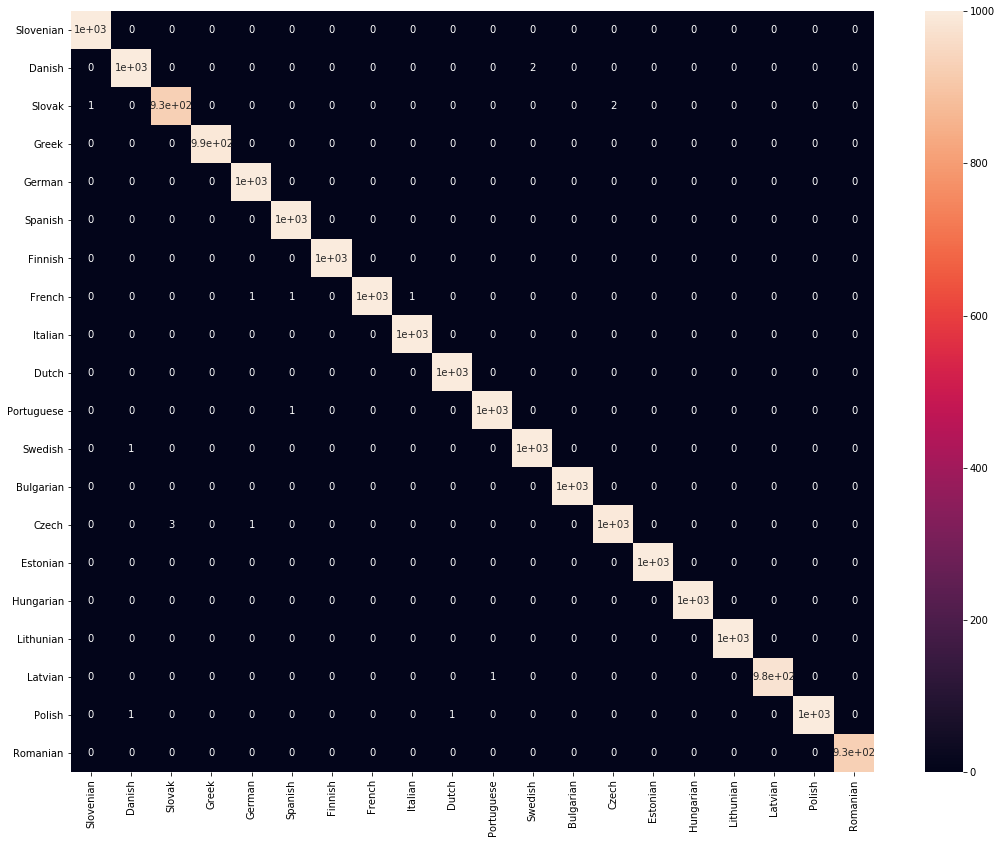

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(df2['code'], pred)
cm_df = pd.DataFrame(cm, index=label_encoding.keys(), columns=label_encoding.keys())

plt.figure(figsize=(18, 14))
sns.heatmap(cm_df, annot=True)

plt.show()